# Détection de communautés dans de grands graphes aléatoires.
Par Edwin Roussin.

In [ ]:
!pip install scikit-network
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.0 MB/s 
     |████████████████████████████████| 8.1 MB 33.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sknetwork.data import block_model
from sknetwork.linalg import Laplacian
import numpy as np
import scipy.sparse.linalg
import cvxpy as cp
from tqdm import  tqdm 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sknetwork.clustering import KMeans
from sknetwork.embedding import GSVD

In [ ]:
def average_con(M): #retourne le taux de connection moyen des sommets du graphe
    N = np.shape(M)[0] # N = 2*n
    a = 0
    for i in range(0,N):
        for j in range(i+1,N):
            a += M[i,j]
    return 2*a / (N*(N-1))

class SBM(object): # classe permettant de créer et manipuler des graphes issue du modèle SBM
    
    def __init__(self,n,p,q):
        self.n = n
        self.p = p
        self.q = q
        self.graph = block_model([n,n], p_in= p, p_out= q, metadata=True)
        self.adjacency = self.graph.adjacency #forme bool non manipulable
        self.laplacian = Laplacian(self.adjacency) #forme numérique
        self.labels = self.graph.labels
        self.adj_matrix = self.laplacian.dot(np.eye(2*n)) #presque adjacency matrix

        
    def exp_matrix(self):
        #diag = self.p*np.ones(2*self.n)
        diag = np.random.binomial(1, self.p, 2*self.n)
        np.fill_diagonal(self.adj_matrix,diag)
        return abs(self.adj_matrix) 


class spectral_cluster(object): #classe proposant des méthodes de détéction de communauté à partir de la matrice d'adjacence
    
    def __init__(self,exp_matrix):
        self.exp_matrix = exp_matrix.astype(float)
        self.n = np.shape(self.exp_matrix)[0]//2
        self.community = np.array([1 for i in range(2*self.n)])
        self.average_con = average_con(self.exp_matrix) # (p+q)/2
        self.work_matrix = self.exp_matrix - self.average_con * np.ones((2*self.n,2*self.n))
        self.test = 0
    
        
    def meth_1(self):
        system = scipy.sparse.linalg.eigsh(self.exp_matrix, 2, mode = 'buckling')
        eig_vec = np.array([u[0] for u in system[1]])
        self.community = np.sign(eig_vec)

    def meth_2(self):
        self.test = self.work_matrix
        system = scipy.sparse.linalg.eigsh(self.work_matrix, 1)
        eig_vec = np.array([u[0] for u in system[1]])
        self.community = np.sign(eig_vec)
        
    def convex_relaxation(self):
        X = cp.Variable((2*self.n,2*self.n), symmetric=True)
        constraints = [X >> 0]
        constraints += [X[i,i]==1 for i in range(2*self.n)]
        prob = cp.Problem(cp.Maximize(cp.trace(self.work_matrix @ X)), constraints)
        prob.solve()
        system = scipy.sparse.linalg.eigsh(X.value, 1)
        eig_vec = np.array([u[0] for u in system[1]])
        self.community = np.sign(eig_vec)
        

In [ ]:
def nb_erreur(label_1,label_2): #fonction utile afin d'évaluer le nombre d'erreur dans le clustering en communauté
    err1 = np.sum(abs(label_1-label_2))//2
    err2 = np.sum(abs(label_1+label_2))//2
    err = min(err1,err2)
    return err

def nb_erreur_bis(label_1,label_2): #fonction utile afin d'évaluer le nombre d'erreur dans le clustering en communauté
    err1 = np.sum(abs(1-label_1-label_2))
    err2 = np.sum(abs(label_1-label_2))
    return min(err1,err2)

def perf_asympt(p,q, eps, N_max = 400) : #applique la clustering sur un graphe SBM de paramètres n,p,q en augmentant n jusqu'a avoir un taux d'erreur < eps
        
    N = [20] #on commence avec un graphe à 20 sommets
    Erreur_1 = [1]
    Erreur_2 = [1]
    Erreur_3 = [1]
    Erreur_4 = [1]

    while Erreur_1[-1] > eps and N[-1]< N_max :
        N.append(N[-1]+25) #on incrémente de 25 la taille du graphe
        n = N[-1]
        graph = SBM(n,p,q)
        clustering = spectral_cluster(graph.exp_matrix())
        c_th = np.array([1 for i in range(n)] + [-1 for i in range(n)])
        '''clustering.meth_2()
        c_exp  = clustering.community
        Erreur_2.append(nb_erreur(c_th,c_exp)/(2*n))'''
        clustering.meth_1()
        c_exp  = clustering.community
        Erreur_1.append(nb_erreur(c_th,c_exp)/(2*n))
        clustering.convex_relaxation()
        c_exp = clustering.community
        Erreur_3.append(nb_erreur(c_th,c_exp)/(2*n))
        labels = graph.labels
        kmeans = KMeans(n_clusters=2, embedding_method=GSVD(2))
        new_labels = kmeans.fit_transform(graph.adjacency)
        Erreur_4.append(nb_erreur_bis(labels,new_labels)/(2*n))


    plt.plot(N,Erreur_1, label = 'meth_1')
    #plt.plot(N,Erreur_2, label = 'meth_2') 
    plt.plot(N,Erreur_3, label = 'convex_relax') 
    plt.plot(N,Erreur_4, label = 'k_means') 

    plt.legend()
    plt.xlabel("Taille communauté")
    plt.ylabel("Taux d'ereur classification")
    plt.suptitle("Paramètres: p = {}  q = {}  Précision = {}%".format(p,q,(1-eps)*100))
    plt.title("Taille commu min : {}".format(N[-1]))
    plt.show()
    

def comportement(N, pN, qN) : # p,q varie en 1/n
    
    Erreur_1 = []
    Erreur_2 = []
    Erreur_3 = []
    Erreur_4 = []

    list_N = [i for i in range(50,N,25)]

    for n in tqdm(list_N) :
        
        p, q = pN/n, qN/n
        graph = SBM(n,p,q)
        clustering = spectral_cluster(graph.exp_matrix())
        c_th = np.array([1 for i in range(n)] + [-1 for i in range(n)])
        clustering.meth_1()
        c_exp  = clustering.community
        Erreur_1.append(nb_erreur(c_th,c_exp)/(2*n))       
        '''clustering.meth_2()
        c_exp  = clustering.community
        Erreur_2.append(nb_erreur(c_th,c_exp)/(2*n))'''
        clustering.convex_relaxation()
        c_exp  = clustering.community
        Erreur_3.append(nb_erreur(c_th,c_exp)/(2*n))
        adjacency = graph.adjacency
        labels = graph.labels
        kmeans = KMeans(n_clusters=2, embedding_method=GSVD(2))
        new_labels = kmeans.fit_transform(adjacency)
        Erreur_4.append(nb_erreur_bis(labels,new_labels)/(2*n))


    plt.plot(list_N, Erreur_1, label = 'meth_1')
    #plt.plot(list_N, Erreur_2, label = 'meth_2') 
    plt.plot(list_N, Erreur_3, label = 'convex_relax') 
    plt.plot(list_N, Erreur_4, label = 'k_means') 
    
    plt.legend()
    plt.xlabel("Taille communauté")
    plt.ylabel("Taux d'ereur classification")
    plt.suptitle("Paramètres: N = {} p = {}/N q = {}/N".format(N, pN, qN))
    plt.title("Erreur finale: meth_1 = {}%  meth_?= {}%".format(int(Erreur_1[-1]*1000)/10, int(Erreur_4[-1]*1000)/10))
    plt.show()
    return 
    

100%|██████████| 6/6 [02:04<00:00, 20.83s/it]


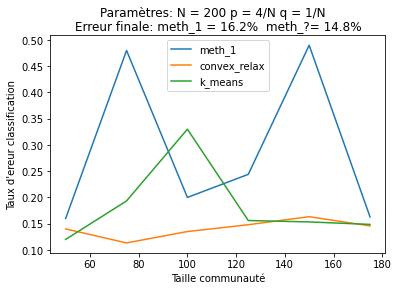

100%|██████████| 6/6 [04:04<00:00, 40.68s/it]


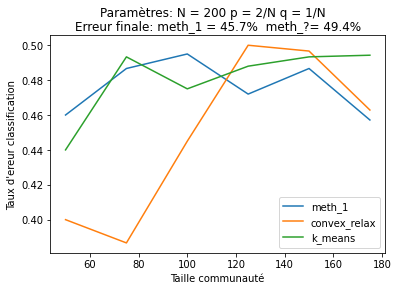

In [ ]:
comportement(200, 4, 1)
comportement(200, 2, 1)



100%|██████████| 6/6 [02:41<00:00, 27.00s/it]


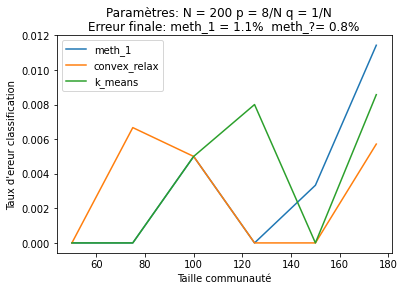

In [ ]:
comportement(200, 8, 1)



In [ ]:
perf_asympt(0.6,0.4,0.05)

100%|██████████| 7/7 [02:21<00:00, 20.19s/it]


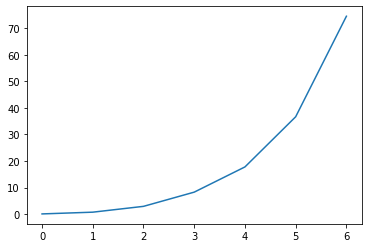

In [ ]:
# relaxation_convexe est très lent pour des grands graphes à cause du Semi definite programming
# cela se voit grâce à ce code qui montre le temps de d'excécution par rapport à la taille du graphe:
p , q = 0.9, 0.1
T =[]
import time
for n in tqdm(range(10,200,30)) :
    graph = SBM(n,p,q)
    clustering = spectral_cluster(graph.exp_matrix())
    A = clustering.work_matrix
    t1 = time.time()
    
    X = cp.Variable((2*n,2*n), symmetric=True)
    constraints = [X >> 0]
    constraints += [X[i,i]==1 for i in range(2*n)]
    objective = cp.Maximize(cp.trace(A @ X))

    prob = cp.Problem( objective, constraints)
    prob.solve()
    
    t2 = time.time()    
    T.append(t2-t1)
    
plt.plot(T)
plt.show()

In [ ]:
# Importons les données polblog
from sknetwork.data import load_netset
from IPython.display import SVG
from sknetwork.visualization import svg_graph


def data_loader():
    
    graph = load_netset('polblogs')
    return graph
'''
image = svg_graph(adjacency, labels = labels)
SVG(image)
'''

'\nimage = svg_graph(adjacency, labels = labels)\nSVG(image)\n'

Parsing files...
Done.


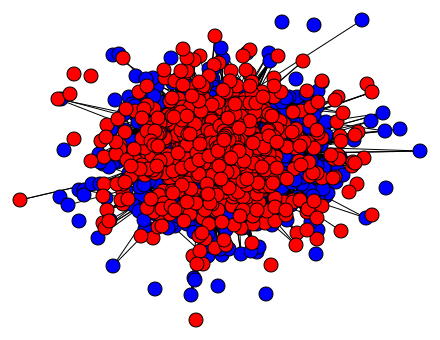

In [ ]:
graph = data_loader()
adjacency = graph.adjacency
labels = graph.labels

image = svg_graph(adjacency, labels = labels)
SVG(image) # on peut visualiser le graphe de polblog, on remarque déjà qu'il y a des points isolés

In [ ]:
# Nous devons éliminer les outlier, cad les éléments du graphes connectés à aucun autre

from scipy import sparse

def average_con(M):
    N = np.shape(M)[0] # N = 2*n
    a = 0
    for i in range(0,N):
        for j in range(i+1,N):
            a += M[i,j]
    return 2*a / (N*(N-1))

#print(average_con(adjacency))

def extract(M,L):
    M_new =  sparse.lil_matrix(sparse.csr_matrix(M)[:,L])
    M_new  = sparse.lil_matrix(sparse.csr_matrix(M_new)[L,:])
    return M_new

def connectivity(M):
    N = np.shape(M)[0] # N = 2*n
    L = []
    for i in tqdm(range(0,N)):
        a = 0
        for j in range(N):
                a+= M[i,j]
        a -= M[i,i]
        L.append(a)
    return L

def index_outlier(L):
    p = len(L)
    J= []
    for i in range(p):
        if L[i]==0:
            J.append(i)
    return J

Con = connectivity(adjacency)
Out = index_outlier(Con)

L = [i for i in range(1490) if i not in Out]
adj = extract(adjacency,L)
adjacency = adj.asformat('csr')

# Sauvegarde du clean graph :

from sknetwork.data import Bunch, load, save

names = list('clean_graph')
graph = Bunch()
graph.adjacency = adjacency
graph.names = np.array(names)
graph.labels = np.array([labels[i] for i in range(1490) if i not in Out])

save('mygraph', graph)

# mygraph est désormais sauvegardé

100%|██████████| 1490/1490 [01:10<00:00, 21.04it/s]


In [ ]:
graph = load('mygraph')
adjacency = graph.adjacency
def new_format(label):
    for i in range(len(label)) :
        if label[i] == -1:
            label[i] = 0

def nb_erreur_bis(label_1,label_2):
    err1 = np.sum(abs(1-label_1-label_2))
    err2 = np.sum(abs(label_1-label_2))
    return min(err1,err2)


def average_con(M):
    N = np.shape(M)[0] # N = 2*n
    a = 0
    for i in range(0,N):
        for j in range(i+1,N):
            a += M[i,j]
    return 2*a / (N*(N-1))

print(average_con(adjacency))

0.015652961189427002


In [ ]:
# Testons la méthode kmean et notre méthode sur les données polblog
labels = graph.labels
kmeans = KMeans(n_clusters=2, embedding_method=GSVD(3))
new_labels = kmeans.fit_transform(adjacency)
print("erreur k_mean on polblog", nb_erreur_bis(labels,new_labels)/np.shape(adjacency)[0])


n = np.shape(adjacency)[0]
laplacian  = Laplacian(adjacency)
exp_matrix = abs(laplacian.dot(np.eye(n)))
np.fill_diagonal(exp_matrix,average_con(exp_matrix)*np.ones(n))
clustering = spectral_cluster(exp_matrix)
clustering.meth_1()
new_format(clustering.community)
new_labels = clustering.community

print("erreur spectral clustering on polblog", nb_erreur_bis(labels,new_labels)/np.shape(adjacency)[0])